<a href="https://colab.research.google.com/github/aycaaozturk/YOLO_image_classification/blob/main/YOLO_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install ultralytics scikit-learn matplotlib --quiet

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:

# 0) Setup & imports



import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
)

from ultralytics import YOLO


np.set_printoptions(linewidth=140, suppress=True)



# 1) Paths & hyperparams

# change this for your dataset
DATA_ROOT = "/content/drive/My Drive/yolov8 format all datasets/nail_dataset/"

#DATA_ROOT = "/content/drive/My Drive/binary classification"

#DATA_ROOT = "/content/drive/My Drive/other nail diseases ALL"

IMG_SIZE   = 224
BATCH_SIZE = 32
EPOCHS     = 20
PROJECT    = "nails_cls"   # Ultralytics "project" folder
RUN_NAME   = "effort101"     # subfolder for this run   HER CALISTIGINDA 1 ARTTIR


# Detect splits
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val") if os.path.isdir(os.path.join(DATA_ROOT, "val")) else \
            os.path.join(DATA_ROOT, "valid") if os.path.isdir(os.path.join(DATA_ROOT, "valid")) else \
            os.path.join(DATA_ROOT, "test")   # fallback if only "test" exists
TEST_DIR  = os.path.join(DATA_ROOT, "test") if os.path.isdir(os.path.join(DATA_ROOT, "test")) else None

for d in [TRAIN_DIR, VAL_DIR]:
    if not os.path.isdir(d):
        raise FileNotFoundError(f"Expected split not found: {d}")




In [13]:
#2) Train YOLOv8 classifier
# Use an ImageNet-pretrained YOLOv8 classifier backbone (n/s/m/l/x). Start with 'n' (smallest).

# classifier: n nano
clf = YOLO("yolov8n-cls.pt")


# train the model
clf.train(
    data=DATA_ROOT,     # root containing train/ val/
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    lr0=1e-3,
    project=PROJECT,
    name=RUN_NAME,
    verbose=True# to print the outcomes

    )




Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/yolov8 format all datasets/nail_dataset/, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=effort101, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pat

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f6986bc0ef0>
curves: []
curves_results: []
fitness: 0.9906103312969208
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9812206625938416, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9906103312969208}
save_dir: PosixPath('/content/nails_cls/effort101')
speed: {'preprocess': 0.05676353520839727, 'inference': 0.5529829953009309, 'loss': 0.0002475610290702647, 'postprocess': 0.0003566337994831623}
task: 'classify'
top1: 0.9812206625938416
top5: 1.0

In [14]:
best_model = clf

In [4]:
# Best weights path (Ultralytics standard)
BEST_WEIGHTS = os.path.join("content", "nails_cls", RUN_NAME, "weights", "best.pt")   # loads the best model (highest val score)
# if not os.path.isfile(BEST_WEIGHTS):
#     # If user changed RUN_NAME or Ultralytics chose expN, try to auto-find the latest run
#     runs = sorted(glob.glob("/content/nails_cls/effort19/weights/best.pt"), key=os.path.getmtime)
#     if not runs:
#         raise FileNotFoundError("Could not find best.pt after training.")
#     BEST_WEIGHTS = runs[-1]
#     print(f"[Info] Using best weights: {BEST_WEIGHTS}")

# Reload model with best weights for evaluation
# best_model = YOLO(BEST_WEIGHTS)
# print("[Info] Loaded best model.")


FileNotFoundError: [Errno 2] No such file or directory: 'content/nails_cls/effort100/weights/best.pt'

'/content/nails_cls/effort1/weights/best.pt'

In [15]:
#3) Helper: list images & labels from a split

# returns the file paths and labels to use for the evaluation metrics

def list_images_and_labels(split_dir):
    """Return (filepaths, labels, class_to_idx, idx_to_class) with classes sorted alphabetically."""
    classes = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
    classes = sorted(classes)  # YOLO uses alphabetical mapping 0..C-1
    class_to_idx = {c: i for i, c in enumerate(classes)}
    idx_to_class = {i: c for c, i in class_to_idx.items()}

    exts = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp")
    filepaths, labels = [], []
    for cls in classes:
        cls_dir = os.path.join(split_dir, cls)
        files = []
        for e in exts:
            files.extend(glob.glob(os.path.join(cls_dir, e)))
        files = sorted(files)
        filepaths.extend(files)
        labels.extend([class_to_idx[cls]] * len(files))

    if len(filepaths) == 0:
        raise RuntimeError(f"No images found under {split_dir}. Check your folder structure.")

    return filepaths, np.array(labels, dtype=int), class_to_idx, idx_to_class


In [16]:
#4) Evaluate on VAL (or TEST) split with rich metrics

# for evaluation -> with the model predictions

EVAL_DIR = TEST_DIR if TEST_DIR else VAL_DIR
eval_name = "TEST" if TEST_DIR else "VAL"
print(f"[Info] Evaluating on {eval_name} split → {EVAL_DIR}")

filepaths, y_true, class_to_idx, idx_to_class = list_images_and_labels(EVAL_DIR)
classes = [idx_to_class[i] for i in range(len(idx_to_class))]
print("Class mapping:", class_to_idx)

# Batch prediction (Ultralytics supports list of paths)
# For classification, result.probs contains scores per class.
results = best_model.predict(
    source=filepaths,
    imgsz=IMG_SIZE,
    verbose=False
)

# Collect probabilities and predicted labels
num_classes = len(classes)
probs = np.vstack([r.probs.data.cpu().numpy() for r in results])   # shape: [N, C]
y_pred = probs.argmax(axis=1)

[Info] Evaluating on TEST split → /content/drive/My Drive/yolov8 format all datasets/nail_dataset/test
Class mapping: {'healthy': 0, 'melanoma': 1, 'other': 2}


In [67]:
y_pred

array([1, 0, 1, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0,

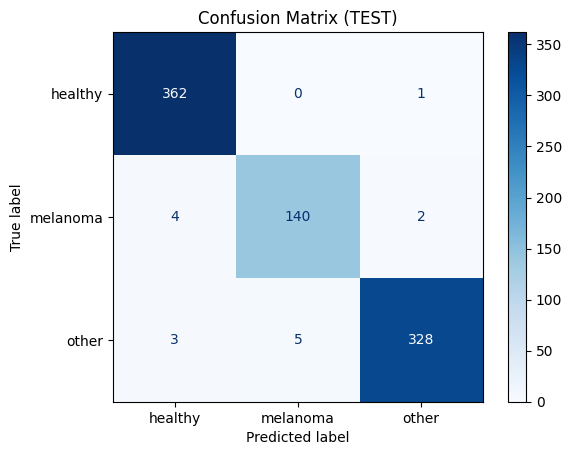

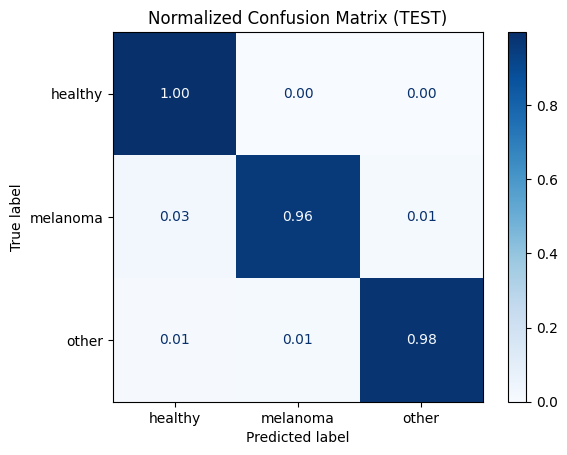


Classification report:
              precision    recall  f1-score   support

     healthy      0.981     0.997     0.989       363
    melanoma      0.966     0.959     0.962       146
       other      0.991     0.976     0.984       336

    accuracy                          0.982       845
   macro avg      0.979     0.977     0.978       845
weighted avg      0.982     0.982     0.982       845



In [17]:
#5) Confusion matrix (counts + normalized)

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix ({eval_name})")
plt.show()

cm_norm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)), normalize="true")
ConfusionMatrixDisplay(cm_norm, display_labels=classes).plot(cmap="Blues", values_format=".2f")
plt.title(f"Normalized Confusion Matrix ({eval_name})")
plt.show()

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=classes, digits=3))


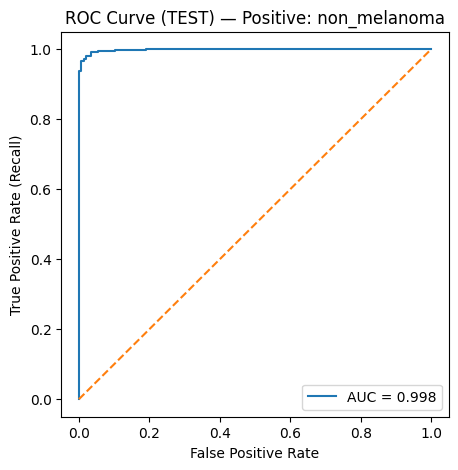

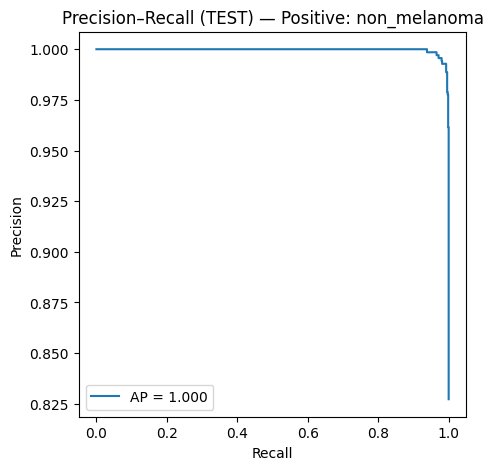

In [9]:
#6) ROC & PR curves (binary only)
# =========================
if num_classes == 2:
    # Choose which class is "positive" (e.g., Melanoma).
    # We'll assume 'Melanoma' exists in classes; otherwise set positive_idx=1.
    positive_class_name = "Melanoma" if "Melanoma" in class_to_idx else classes[1]
    positive_idx = class_to_idx[positive_class_name]

    y_score = probs[:, positive_idx]  # probability of positive class
    y_bin   = (y_true == positive_idx).astype(int)

    # ROC
    fpr, tpr, _ = roc_curve(y_bin, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"ROC Curve ({eval_name}) — Positive: {positive_class_name}")
    plt.legend(); plt.show()

    # Precision-Recall
    prec, rec, _ = precision_recall_curve(y_bin, y_score)
    ap = average_precision_score(y_bin, y_score)
    plt.figure(figsize=(5,5))
    plt.plot(rec, prec, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall ({eval_name}) — Positive: {positive_class_name}")
    plt.legend(); plt.show()

In [10]:
# =========================
# 2.1) Find results.csv of this run
# =========================
import pandas as pd
import glob, os

# Ultralytics saves here because you passed project/name
RUN_DIR = f"/content/{PROJECT}/{RUN_NAME}"
if not os.path.isdir(RUN_DIR):                   # in case Ultralytics renamed to expN
    candidates = sorted(glob.glob(f"/content/{PROJECT}/**", recursive=True), key=os.path.getmtime)
    candidates = [d for d in candidates if os.path.isdir(d)]
    RUN_DIR = candidates[-1]                      # latest folder

csv_path = os.path.join(RUN_DIR, "results.csv")
if not os.path.isfile(csv_path):
    raise FileNotFoundError(f"results.csv not found under {RUN_DIR}")

df = pd.read_csv(csv_path)
print("columns:", list(df.columns))


columns: ['epoch', 'time', 'train/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5', 'val/loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


KeyError: 'train/accuracy_top1'

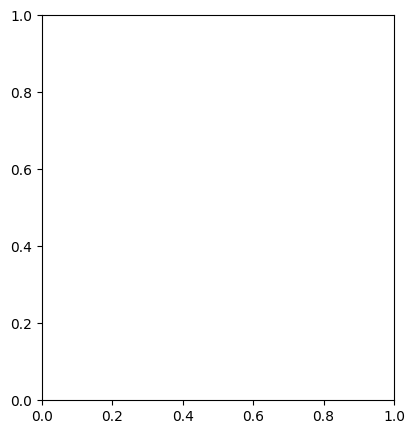

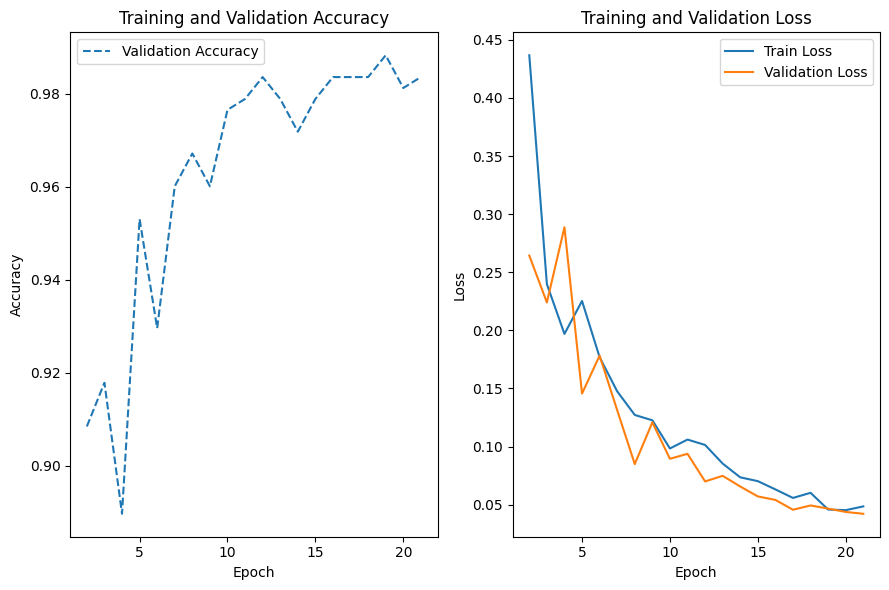

In [11]:
# =========================
# 2.2) Plot Training vs Validation Accuracy/Loss
# =========================
import matplotlib.pyplot as plt

epochs = df["epoch"].values + 1  # make epochs 1-based for the x-axis

# Common column names for Ultralytics cls:
acc_col   = "metrics/accuracy_top1"  # top-1 accuracy
tr_loss   = "train/loss"
val_loss  = "val/loss"

plt.figure(figsize=(9,6))

# --- Accuracy ---
plt.subplot(1,2,1)
#plt.plot(epochs, df[acc_col], label="Train Accuracy (top-1)")
# Ultralytics logs only one accuracy column (computed on val set each epoch).
# If you also want a "train accuracy" line, keep the same one or compute manually.
plt.plot(epochs, df[acc_col], linestyle="--", label="Validation Accuracy")  # same as above
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# --- Loss ---
plt.subplot(1,2,2)
plt.plot(epochs, df[tr_loss], label="Train Loss")
plt.plot(epochs, df[val_loss], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#7) Threshold tuning by F1 (binary)
    # =========================
    ths = np.linspace(0, 1, 101)
    f1s = []
    for t in ths:
        y_pred_thr = (y_score >= t).astype(int)
        f1s.append(f1_score(y_bin, y_pred_thr))
    best_idx = int(np.argmax(f1s))
    best_t, best_f1 = ths[best_idx], f1s[best_idx]
    print(f"Best threshold by F1: {best_t:.2f} (F1={best_f1:.3f})")

    plt.figure(figsize=(6,4))
    plt.plot(ths, f1s)
    plt.axvline(best_t, linestyle="--")
    plt.xlabel("Threshold"); plt.ylabel("F1 score"); plt.title("F1 vs Threshold")
    plt.show()

    # CM at best threshold
    y_pred_best = (y_score >= best_t).astype(int)
    cm_best = confusion_matrix(y_bin, y_pred_best, labels=[0,1])
    ConfusionMatrixDisplay(cm_best, display_labels=[f"Not {positive_class_name}", positive_class_name]).plot(
        cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix @ Best F1 (t={best_t:.2f}) — {eval_name}")
    plt.show()
else:
    print("[Info] ROC/PR & threshold tuning are shown only for binary classification.")




IndentationError: unexpected indent (ipython-input-97869195.py, line 3)

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/nails_cls/effort1/weights/best.pt")

In [ ]:
val_dir = "/content/drive/My Drive/yolov8 format all datasets/nail_dataset/val"
results = model.predict(source=f"{val_dir}/**", imgsz=224, verbose=False)


In [ ]:
probs = [r.probs.data.cpu().numpy() for r in results]


In [ ]:
import os, glob
import numpy as np

# Get class order (alphabetical)
classes = sorted(os.listdir(val_dir))
class_to_idx = {c: i for i, c in enumerate(classes)}

# Collect true labels
true_labels = []
filepaths = []
for cls in classes:
    files = glob.glob(os.path.join(val_dir, cls, "*.jpg")) \
          + glob.glob(os.path.join(val_dir, cls, "*.png"))
    filepaths.extend(files)
    true_labels.extend([class_to_idx[cls]] * len(files))

true_labels = np.array(true_labels)


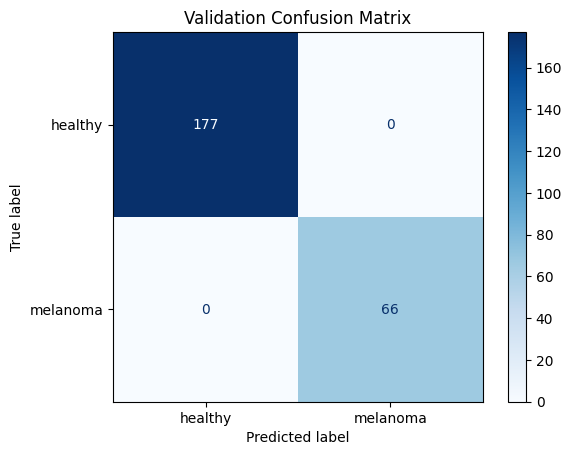

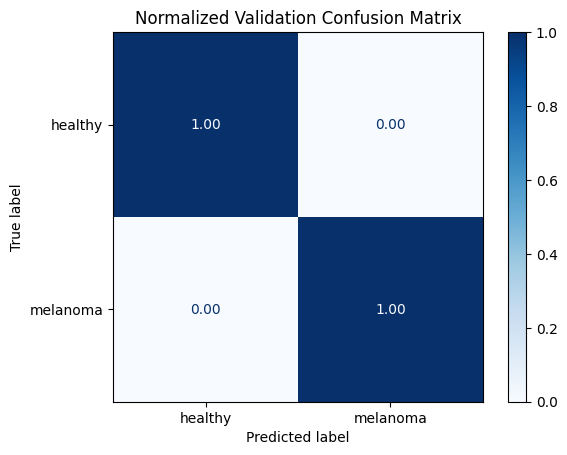

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicted class indices (argmax of probabilities)
pred_labels = np.array([p.argmax() for p in probs])

# Compute CM
cm = confusion_matrix(true_labels, pred_labels)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Blues", values_format="d")
plt.title("Validation Confusion Matrix")
plt.show()

# Optionally normalized (percentage per actual class)
cm_norm = confusion_matrix(true_labels, pred_labels, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes)
disp_norm.plot(cmap="Blues", values_format=".2f")
plt.title("Normalized Validation Confusion Matrix")
plt.show()


In [ ]:
# =========================
# 8) (Optional) Validate via YOLO's built-in validator
# =========================
# You can also call the built-in validator; it reports top-1/top-5 accuracy etc.
metrics = best_model.val(split="val" if os.path.basename(VAL_DIR) in ("val", "valid") else "test")
print("\nUltralytics val() metrics:", metrics)